## CREDIT CARD FRAUD

Fraud activities are considered uncommon or outliers transactions, which is probably one of the main characteristics regarding Fraud. As the authors of the book Fraud Analytics using Descriptive, Predictive, and Social Network Techniques: A Guide to Data Science for Fraud Detection pointed out:

“This makes it difficult [because of the outlier characteristic] to both detect fraud, since the fraudulent cases are covered by the nonfraudulent ones, as well as to learn from historical cases to build a powerful fraud-detection system since only few examples are available”

Hence, it is imperative to overcome this issue considering the unbalanced nature of the data. 

In this project, we will use the credit card data available in https://www.kaggle.com/mlg-ulb/creditcardfraud. Moreover, we will use PySpark, an Interface for Apache Spark in Python, since it is an excellent tool dealing with Big Data.

Feature Technicalities:

    PCA Transformation: The description of the data says that all the features went through a PCA transformation (Dimensionality Reduction technique) (Except for time and amount).
    Scaling: In order to implement a PCA transformation features need to be previously scaled. (In this case, all the V features have been scaled)

## EXPLORATORY DATA ANALYSIS

Firstly we need to import the necessary libraries and configure the Spark session. After that, we load our data set, in order to analyse it, and perform EDA.

In [1]:
# Import libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Import PySpark libraries
from pyspark.sql import Window
import pyspark.sql.types as t
import pyspark.sql.functions as f
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.feature import StringIndexer, VectorIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

import warnings
warnings.filterwarnings('ignore')

import pyspark.sql.functions as f
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("xpto") \
    .getOrCreate()
sc = spark.sparkContext

In [2]:
# Load file
df = spark.read.csv('creditcard.csv', header=True, inferSchema=True, sep=",")
# Print Schema
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

It appears that the dataset has a total of 31 columns, in which 28 of them are components that are results of PCA. Columns V1-V28 are going to be more abstract, since we don't have a clear definition/description of what they represent.

In [3]:
df.limit(10).toPandas()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [4]:
# Spark DataFrame Shape
print(f"Number of columns: {len(df.columns)}")
print(f"Number of Records: {df.count()}")

Number of columns: 31
Number of Records: 284807


The dataset contains 284,807 records and consists of 31 columns. Out of these columns, 28 columns (V1 to V28) are results of the Principal Component Analysis (PCA) technique. These columns are likely to be more abstract in nature since they are generated from linear combinations of the original features. Therefore, it may be difficult to interpret the individual contributions of these features towards the prediction task.

On the other hand, the remaining three columns are:

    Time: This column indicates the time elapsed in seconds between each transaction and the first transaction in the dataset.
    Amount: This column indicates the transaction amount.
    Class: This column indicates the fraud status of the transaction. The value 1 indicates fraud, and 0 indicates a legitimate transaction.

It is important to note that since the PCA technique is used, the original feature names and descriptions are not available. Therefore, feature engineering might be necessary to extract meaningful features from the given dataset.

In [5]:
#statistics
df.toPandas().describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.205498e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406306e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


The dataset contains a total of 284807 records. The time column in the dataset indicates the time elapsed in seconds between each transaction and the first transaction in the dataset. The maximum time recorded between transactions is 172,792 seconds. This is equivalent to 2880 minutes or approximately 48 hours. Since the timeframe of the dataset is only 2 days, it means that the last transaction was made two days after the first one.

The amount column indicates the transaction amount. The biggest transaction recorded in the dataset is worth $25,691.16.

## 1.1 Checking Missing Values

In [6]:
#Check missing and null data
df.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



Upon checking the dataset, it was observed that there are no missing values present. Each column was inspected for null or NaN values, and it was found that the dataset is complete!

## 1.2 Checking Duplicates

In [7]:
#Distinct
distinctDF = df.distinct()
print("Distinct count: "+str(distinctDF.count()))

Distinct count: 283726


In [8]:
#Drop duplicates
df = df.dropDuplicates()
print("Distinct count: "+str(df.count()))

Distinct count: 283726


Upon checking the dataset, it was observed that there are 1081 rows duplicated. That rows were removed from the dataset.

## 1.3 Univariate Analysis

## 1.3.1 Class

HOW MANY ROWS IN THE DATASET REPRESENT CREDIT CARD FRAUD?

In [9]:
#Number of Frauds and non-frauds
classFreq = df.groupBy("Class").count()
classFreq.show()

+-----+------+
|Class| count|
+-----+------+
|    1|   473|
|    0|283253|
+-----+------+



In [10]:
total = classFreq.select("count").agg({"count": "sum"}).collect().pop()['sum(count)']
result = classFreq.withColumn('percent', (classFreq['count']/total) * 100)
result.show()

+-----+------+------------------+
|Class| count|           percent|
+-----+------+------------------+
|    1|   473|0.1667101358352777|
|    0|283253| 99.83328986416473|
+-----+------+------------------+



Out of the total of 284,807 records, only 492 represent credit card fraud, which is approximately 0.17% of the dataset. Therefore, we have an imbalanced dataset.

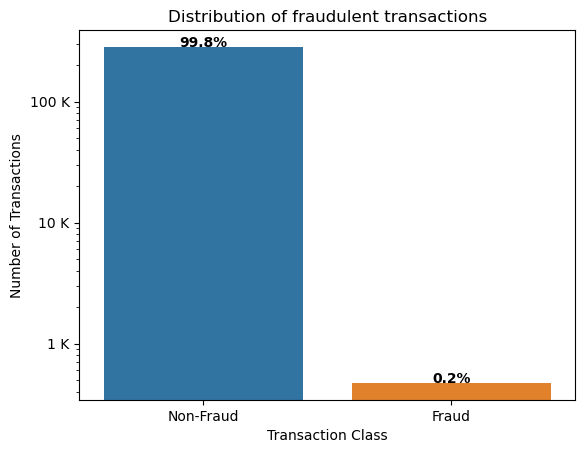

In [11]:
fraud_df = df.select("Class").toPandas()

# Count the number of transactions for each class (fraudulent or not)
fraud_counts = fraud_df['Class'].value_counts()

# Calculate the percentage of each class
fraud_perc = fraud_counts / fraud_counts.sum() * 100

# Create a bar plot with logarithmic y-axis
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.yscale('log')

# Add percentage labels to the bars
for i, v in enumerate(fraud_counts):
    plt.text(i, v, f"{fraud_perc[i]:.1f}%", ha='center', fontweight='bold')

# Set the y-axis labels and formatter
plt.ylabel('Number of Transactions')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f} K'.format(x/1000)))

# Set the axis labels and title
plt.xlabel('Transaction Class')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.title('Distribution of fraudulent transactions')

plt.show()

As mentioned earlier, the majority of transactions are legitimate. If we use this dataset as the foundation for our predictive models and analysis, we may encounter many errors, and our algorithms are likely to overfit since they will "presume" that most transactions are not fraudulent. However, we do not want our model to presume; we want our model to identify patterns that indicate fraud.

## 1.3.2 Amount

In [12]:
# create a function to group time values
@f.udf(returnType=t.StringType())
def time_udf(time):
    if time < 50000:
        return "Under 50K s"
    elif 50000 <= time <= 100000:
        return "Between 50K and 100K s"
    elif time > 100000:
        return "Over 100K s"
    else:
        return "NA"

# apply the function to the "Time" column
df = df.withColumn('time_udf', time_udf('Time'))

df.limit(10).toPandas()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,time_udf
0,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0,Under 50K s
1,158.0,-0.600816,0.922455,-0.135952,-1.259915,2.439824,3.330205,0.087107,0.949659,-0.327932,...,-0.927233,-0.045268,0.979587,0.016423,0.091043,0.371280,0.180187,1.79,0,Under 50K s
2,190.0,-1.505779,-0.215325,1.991294,-1.631493,-0.635965,0.228414,-0.034266,0.042696,-0.235440,...,0.148146,-0.450115,-0.396558,0.554224,-0.340493,-0.335618,-0.413379,82.29,0,Under 50K s
3,265.0,-0.491003,0.906953,1.645423,-0.083531,-0.195560,-0.710165,0.559119,0.116340,-0.538190,...,-0.517387,0.018650,0.491652,-0.277795,0.043841,0.253372,0.111749,9.03,0,Under 50K s
4,459.0,-0.528218,0.981232,1.652988,-0.150715,0.137048,-0.203980,0.583370,0.165246,-0.781696,...,-0.272731,0.023887,0.223936,-0.297777,0.068300,0.281018,0.111557,6.99,0,Under 50K s
5,775.0,-3.900810,-3.098370,-0.213428,-2.678434,-2.927576,0.735688,1.591471,-3.465433,1.812757,...,-0.097578,-4.020300,0.191246,-0.204492,-1.076721,1.072961,-0.188497,1528.90,0,Under 50K s
6,926.0,-1.536958,-0.041422,0.629846,-0.687015,0.796080,-0.485757,-0.302744,0.737427,-0.069131,...,-0.701171,-0.184521,-0.851564,-0.129501,0.345511,0.178534,-0.054153,1.00,0,Under 50K s
7,943.0,-1.212502,-0.058851,1.823435,-0.891164,-0.455972,1.330098,-0.631760,1.245756,0.774278,...,0.039612,0.233519,-0.621402,-0.463379,0.897888,-0.121907,-0.101759,48.94,0,Under 50K s
8,1261.0,-0.883529,1.173974,0.967298,1.125954,-0.518899,-1.139359,0.413262,0.136250,-0.666178,...,0.456075,-0.126655,0.940618,-0.078312,-0.353976,-0.275187,-0.038647,34.15,0,Under 50K s
9,1293.0,-1.434348,0.012470,3.327386,-0.738225,-0.630525,1.669713,-0.685391,0.674718,1.695032,...,0.965753,-0.342583,-0.157691,0.194028,1.204821,0.129031,-0.041771,8.00,0,Under 50K s


In [13]:
# Define window function with partitionBy clause
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Create time group table
time_group_table = df.select("time_udf", "Amount"). \
    groupBy("time_udf"). \
    agg(
    f.count("Amount").alias("UserCount"),
    f.mean("Amount").alias("Amount_Avg"),
    f.min("Amount").alias("Amount_Min"),
    f.max("Amount").alias("Amount_Max")). \
    withColumn("total", f.sum("UserCount").over(window)). \
    withColumn("Percent", f.round(f.col("UserCount")*100 / f.col("total"), 2)). \
    drop("total"). \
    orderBy(f.desc("Percent"))

time_group_table.limit(10).toPandas()

,time_udf,UserCount,Amount_Avg,Amount_Min,Amount_Max,Percent
0,Over 100K s,130560,88.258712,0.0,25691.16,46.02
1,Between 50K and 100K s,91602,83.923336,0.0,18910.00,32.29
2,Under 50K s,61564,95.695518,0.0,19656.53,21.70


Here we computed some statistics with the "Amount" column, divided by the three time groups defined earlier. Now let's plot our results:

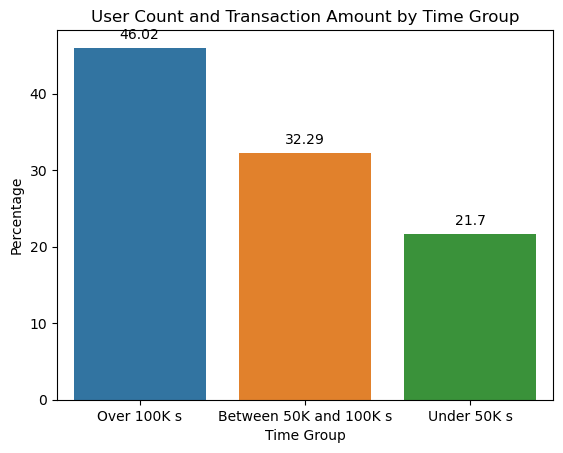

In [14]:
# Convert PySpark dataframe to Pandas dataframe
time_group_df = time_group_table.toPandas()

# Create barplot
ax = sns.barplot(x="time_udf", y="Percent", data=time_group_df)

for p in ax.patches:
    abs_value = p.get_height()
    ax.annotate(f'{abs_value}',
                (p.get_x() + p.get_width() / 2., abs_value),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.title("User Count and Transaction Amount by Time Group")
plt.xlabel("Time Group")
plt.ylabel("Percentage")
plt.show();

After analysing the graph, we conclude that the largest percentage for the Amount values is found when the time between each transaction recorded is over 100 000 seconds.

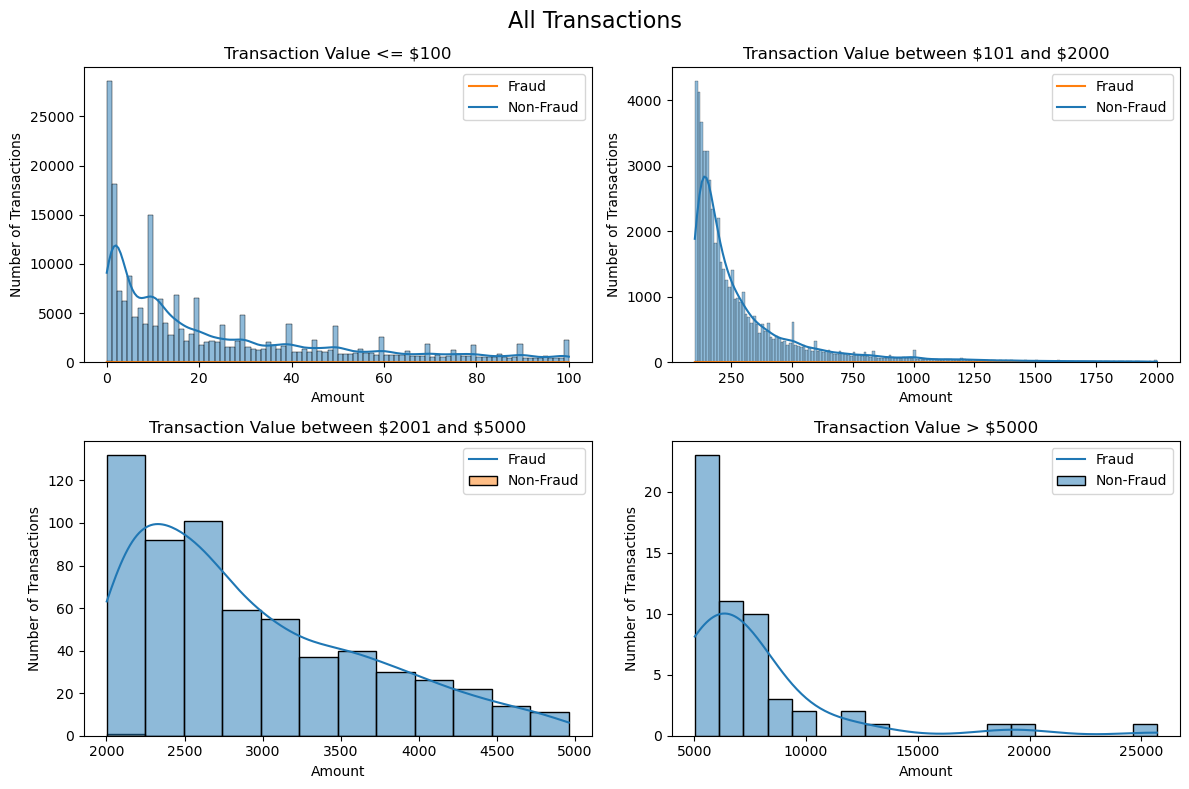

In [15]:
# All Transactions
df_aux = df.select("Class", "Amount").toPandas()

# Define amount ranges
amount_ranges = [
    {"range": "Transaction Value <= $100", "min_amount": 0, "max_amount": 100},
    {"range": "Transaction Value between \$101 and \$2000", "min_amount": 101, "max_amount": 2000},
    {"range": "Transaction Value between \$2001 and \$5000", "min_amount": 2001, "max_amount": 5000},
    {"range": "Transaction Value > $5000", "min_amount": 5001, "max_amount": df_aux["Amount"].max()}
]

# Create four subplots for different amount ranges
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for idx, amount_range in enumerate(amount_ranges):
    row_idx = idx // 2
    col_idx = idx % 2

    # Filter transactions within amount range
    df_range = df_aux[(df_aux["Amount"] > amount_range["min_amount"]) & (df_aux["Amount"] <= amount_range["max_amount"])]

    # Plot histogram
    sns.histplot(data=df_range, x="Amount", ax=axes[row_idx, col_idx], hue="Class", kde=True)
    axes[row_idx, col_idx].set_title(amount_range["range"])
    axes[row_idx, col_idx].set_ylabel("Number of Transactions")
    axes[row_idx, col_idx].legend(labels=["Fraud", "Non-Fraud"])

fig.suptitle("All Transactions", fontsize=16)
plt.tight_layout()
plt.show()

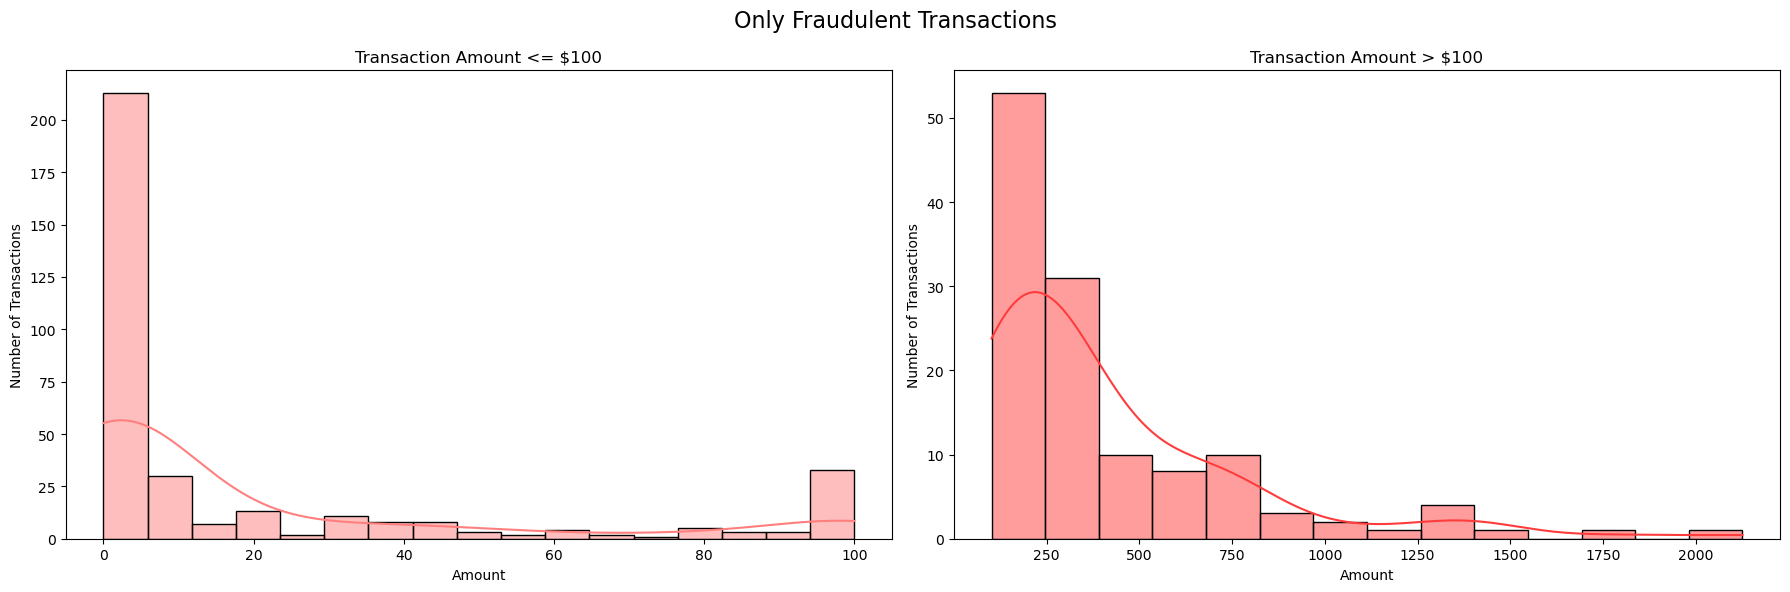

In [16]:
# Only fraud transactions
only_fraud = df.filter(df.Class == 1).select("Amount").toPandas()

# Add a pallet
aux_pal = ["#ff7f7f", "#ff3c3c"]

# Create three subplots for different amount ranges
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Amount range <= 100
sns.histplot(data=only_fraud[only_fraud["Amount"] <= 100], x="Amount", ax=axes[0], kde=True, color=aux_pal[0])
axes[0].set_title("Transaction Amount <= $100")
axes[0].set_ylabel("Number of Transactions")

# Amount range > 100
sns.histplot(data=only_fraud[(only_fraud["Amount"] > 100)], x="Amount", ax=axes[1], kde=True, color=aux_pal[1])
axes[1].set_title("Transaction Amount > $100")
axes[1].set_ylabel("Number of Transactions")

fig.suptitle("Only Fraudulent Transactions", fontsize=16)
plt.tight_layout()
plt.show()

## 1.3.3 Remaining variables

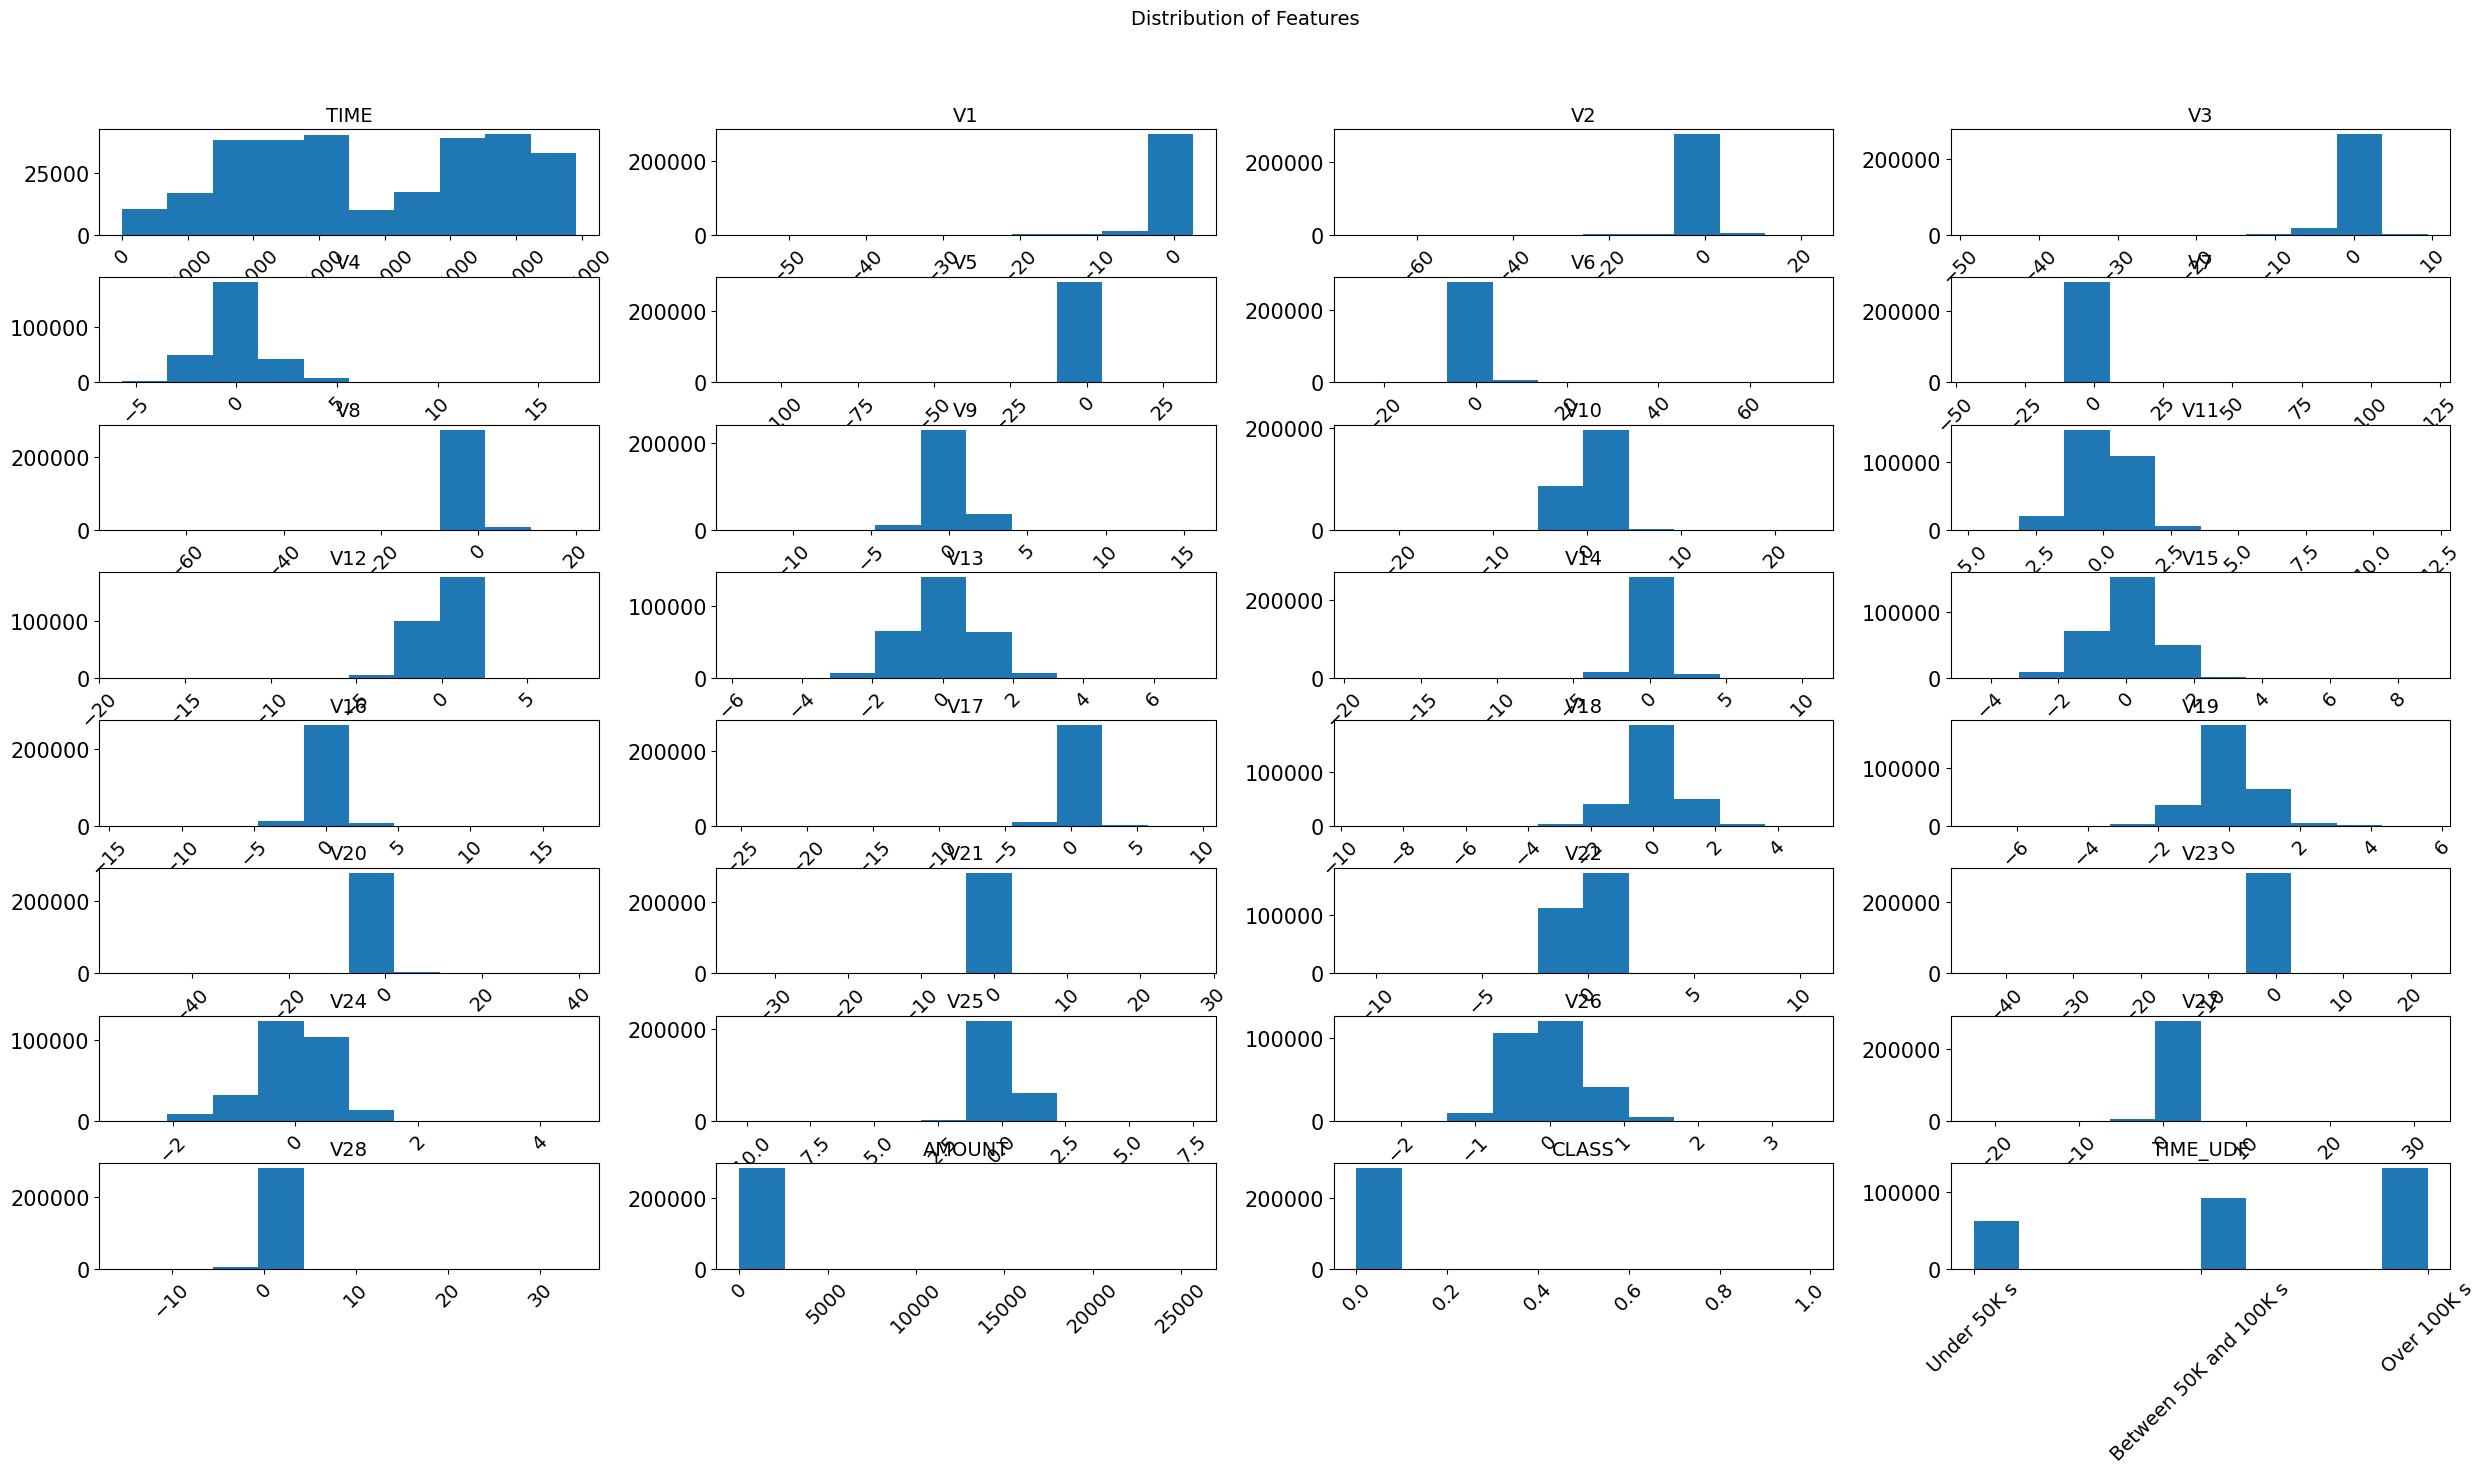

In [17]:
# create several histograms to show the distributions of the features
fig, axs = plt.subplots(8, 4, figsize=(25, 15))
fig.suptitle("Distribution of Features", fontsize=14)

for col, ax in zip(df.columns, axs.flatten()):
    ax.hist(df.select(col).toPandas()[col])
    ax.grid(False)
    ax.tick_params(axis='x', labelrotation=45, labelsize=14)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(col.upper(), fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.4)
plt.show()

Through the histograms, we can observe that the feature "Time" does not follow a normal distribution, with a lower occurrence in the range of 75,000-100,000 seconds. On the other hand, the features Vx show a normalized distribution centered around the value 0, with some negative values.

## 1.4 Normalization

Scaling and normalization is another common task that we come across while handling continuous variables. It is not always imperative but, highly recommended to scale and normalize the features before applying an ML algorithm in order to avert the risk of an algorithm being insensitive to a certain features.

Spark ML provides a class “StandardScaler” for easy scaling and normalization of features.The normalization is particular important for the columns Time and Amount that dont have been normalized previously. 

In [18]:
# UDF for converting column type from vector to double type
unlist = f.udf(lambda x: round(float(list(x)[0]),3), t.DoubleType())

In [19]:
# Iterating over columns to be scaled
for i in ['Time', 'V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount']:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # StandardScaler Transformation
    scaler = StandardScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    df = pipeline.fit(df).transform(df).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

In [20]:
dfscaled = df.drop('Time', 'V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount', 'time_udf')

In [21]:
dfscaled.printSchema()

root
 |-- Class: integer (nullable = true)
 |-- Time_Scaled: double (nullable = true)
 |-- V1_Scaled: double (nullable = true)
 |-- V2_Scaled: double (nullable = true)
 |-- V3_Scaled: double (nullable = true)
 |-- V4_Scaled: double (nullable = true)
 |-- V5_Scaled: double (nullable = true)
 |-- V6_Scaled: double (nullable = true)
 |-- V7_Scaled: double (nullable = true)
 |-- V8_Scaled: double (nullable = true)
 |-- V9_Scaled: double (nullable = true)
 |-- V10_Scaled: double (nullable = true)
 |-- V11_Scaled: double (nullable = true)
 |-- V12_Scaled: double (nullable = true)
 |-- V13_Scaled: double (nullable = true)
 |-- V14_Scaled: double (nullable = true)
 |-- V15_Scaled: double (nullable = true)
 |-- V16_Scaled: double (nullable = true)
 |-- V17_Scaled: double (nullable = true)
 |-- V18_Scaled: double (nullable = true)
 |-- V19_Scaled: double (nullable = true)
 |-- V20_Scaled: double (nullable = true)
 |-- V21_Scaled: double (nullable = true)
 |-- V22_Scaled: double (nullable = true)

## 1.5 Outliers

In [22]:
def find_outliers(dfscaled):

    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in dfscaled.dtypes if column[1]=='double']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = dfscaled.approxQuantile(column,[0.25],relativeError=0)
        Q3 = dfscaled.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        dfscaled = dfscaled.withColumn(isOutlierCol,f.when((dfscaled[column] > more_Q3) | (dfscaled[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in dfscaled.columns if column.startswith("is_outlier")]

    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    dfscaled = dfscaled.withColumn('total_outliers',sum(dfscaled[column] for column in selected_columns))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    dfscaled = dfscaled.drop(*[column for column in dfscaled.columns if column.startswith("is_outlier")])

    return dfscaled
    

In [23]:
new_df = find_outliers(dfscaled)
new_df.show()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
new_df_with_no_outliers = new_df.filter(new_df['total_Outliers']<=1)
new_df_with_no_outliers = new_df_with_no_outliers.select(*dfscaled.columns)

new_df_with_no_outliers.show()

In [ ]:
new_df_with_no_outliers.count()

In [ ]:
data_with_outliers = new_df.filter(new_df['total_Outliers']>=2)
data_with_outliers.show()

In [ ]:
# Convert the Spark dataframe to a pandas dataframe
fraud_df = new_df_with_no_outliers.select("Class").toPandas()

# Create a countplot with logarithmic y-axis
sns.countplot(x='Class', data=fraud_df, order=[1, 0])

# Calculate the percentage of each class
fraud_counts = fraud_df['Class'].value_counts()
fraud_perc = fraud_counts / fraud_counts.sum() * 100

# Set the y-axis labels and formatter
plt.ylabel('Number of Transactions')

# Set the axis labels and title
plt.xlabel('Transaction Class')
plt.xticks([0, 1], ['Fraud', 'Non-Fraud'])
plt.title('Distribution of Transactions Without Ouliers')

plt.show()

## 1.6 Imbalanced data

To address the imbalanced data issue, we will implement the technique of Random Under Sampling. The aim is to balance the dataset by removing data, which helps to avoid model overfitting.

Steps:

    1) The first thing we have to do is determine how imbalanced is our class (use "value_counts()" on the class column to determine the amount for each label)
    2) Once we determine how many instances are considered fraud transactions (Fraud = "1") , we should bring the non-fraud transactions to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.
    3) After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to shuffle the data to see if our models can maintain a certain accuracy everytime we run this script.
    
Note: The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of information loss (bringing 492 non-fraud transaction from 284,315 non-fraud transaction)

However, Using the original dataframe will cause the following issues:

    Overfitting: Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraud occurs.
    Wrong Correlations: Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features.

In [ ]:
# Select fraud and non-fraud transactions and limit non-fraud transactions to the same number as fraud transactions
fraud_df = dfscaled.filter(f.col('Class') == 1)
non_fraud_df = dfscaled.filter(f.col('Class') == 0).limit(fraud_df.count())

# Combine fraud and non-fraud transactions and shuffle the data
balanced_df = fraud_df.union(non_fraud_df).orderBy(f.rand())

# Show 10 rows of the shuffled, balanced dataframe
balanced_df.limit(10).toPandas()

In [ ]:
# Convert the Spark dataframe to a pandas dataframe
fraud_df = balanced_df.select("Class").toPandas()

# Create a countplot with logarithmic y-axis
sns.countplot(x='Class', data=fraud_df, order=[1, 0])

# Calculate the percentage of each class
fraud_counts = fraud_df['Class'].value_counts()
fraud_perc = fraud_counts / fraud_counts.sum() * 100

# Set the y-axis labels and formatter
plt.ylabel('Number of Transactions')

# Set the axis labels and title
plt.xlabel('Transaction Class')
plt.xticks([0, 1], ['Fraud', 'Non-Fraud'])
plt.title('Balanced Distribution of Transactions')

plt.show()

Now that we have our dataframe correctly balanced, we can go further with our analysis and data preprocessing.

## Correlations

Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (Balanced) in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

Summary and Explanation:

    Negative Correlations: V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.
    Positive Correlations: V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.
    BoxPlots: We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions.
    
Note: We have to make sure we use the subsample in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imbalance in the original dataframe.

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.heatmap(dfscaled.toPandas().corr(), cmap='coolwarm_r')
plt.title('Correlations with Unbalanced Data')

plt.subplot(1, 2, 2)
sns.heatmap(balanced_df.toPandas().corr(), cmap='coolwarm_r')
plt.title('Correlations with Balanced Data')

plt.show()

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.heatmap(balanced_df.toPandas().corr() > 0.7,cbar=False, annot_kws={'size':20})
plt.title('Correlations with Balanced Data > 0.7')

plt.subplot(1, 2, 2)
sns.heatmap(balanced_df.toPandas().corr() < -0.7,cbar=False, annot_kws={'size':20})
plt.title('Correlations with Balanced Data < -0.7')

plt.show();

Conclusions from Correlation Matrix

Based on our correlation matrix, we have concluded the following:

    The variables that were a product of PCA are not correlated with each other, meaning they are independent.
    The variable "Time" seems to be negatively correlated with all of the "Vx" variables, which means that as "Time" increases, the values of "Vx" decrease, and vice versa.
    The variables "Time" and "Class" seem to have no correlation, indicating that the time at which a transaction occurs has no influence on whether it is fraudulent or not.
    The variable "Class" seems to be negatively correlated with some of the "Vx" variables, indicating that certain values of "Vx" are more likely to be associated with fraudulent transactions, while not correlated at all with others.

## Distributions: Univariate

In [ ]:
# select all columns except the ones to exclude
cols_to_include = [col for col in balanced_df.columns if col not in ['Time']]
df_to_plot = balanced_df.select(*cols_to_include)

for col in df_to_plot.columns:
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # plot histogram
    axs[0].hist(df_to_plot.select(col).rdd.flatMap(lambda x: x).collect(), bins=50)
    axs[0].set_title(f"Distribution of {col} values", size=14)
    axs[0].set_xlabel(col, size=12)
    axs[0].set_ylabel("Count", size=12)

    # plot boxplot
    sns.boxplot(data=df_to_plot.select(col).toPandas(), x=col, ax=axs[1])
    axs[1].set_title(f"{col} Boxplot", size=14)
    axs[1].set_xlabel(col, size=12)
    axs[1].set_ylabel("Count", size=12)

plt.show();

## Distributions: Bivariate

In [ ]:
bounds={}
fig,ax=plt.subplots(3,10, figsize=(50,30))
i=0
for col in df_to_plot.columns:
    plt.title(col, size= 14)
    sns.boxplot(x='Class',y=col,data=df_to_plot.toPandas(),ax=ax[i//10][i%10],whis=10)
    ax[i//10][i%10].set_title(col, size= 14)
    i=i+1
    quantiles = df_to_plot.approxQuantile(col,[0.25,0.75],0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5*IQR,quantiles[1] + 1.5*IQR]
    
plt.show()

## With Correlation > 0.7

In [ ]:
bounds={}
fig,ax=plt.subplots(1,4, figsize=(50,10))
i=0
for col in df_to_plot.select("V4_Scaled", "V11_Scaled", "V2_Scaled", "V19_Scaled").columns:
    plt.title(col, size= 14)
    sns.boxplot(x='Class',y=col,data=df_to_plot.toPandas(),ax=ax[i],whis=1.5)
    ax[i].set_title(col, size= 14)
    i=i+1
    quantiles = df_to_plot.approxQuantile(col,[0.25,0.75],0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5*IQR,quantiles[1] + 1.5*IQR]
    
plt.show()

## With Correlation <- 0.7

In [ ]:
bounds={}
fig,ax=plt.subplots(1,4, figsize=(50,10))
i=0
for col in df_to_plot.select("V14_Scaled", "V12_Scaled", "V10_Scaled", "V16_Scaled").columns:
    plt.title(col, size= 14)
    sns.boxplot(x='Class',y=col,data=df_to_plot.toPandas(),ax=ax[i],whis=1.5)
    ax[i].set_title(col, size= 14)
    i=i+1
    quantiles = df_to_plot.approxQuantile(col,[0.25,0.75],0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5*IQR,quantiles[1] + 1.5*IQR]
    
plt.show()

In [ ]:
hist_fraud = df_to_plot.filter(f.col('Class') == 1).drop('Class').toPandas()

hist_fraud.hist(bins=30, figsize=(10, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.8)
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = hist_fraud['V14_Scaled'].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = hist_fraud['V12_Scaled'].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = hist_fraud['V10_Scaled'].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [ ]:
for i in hist_fraud.columns:
    plt.figure()

    sns.set(rc={"figure.figsize":(8, 5)})
    fig, (ax_hist) = plt.subplots(1, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Density')
    #sns.histplot(new_df[i], ax=ax_hist ,  bins = 20, kde=True)
    sns.distplot(hist_fraud[i], ax=ax_hist, fit=norm, color='#FB8861')
plt.tight_layout()
plt.show();